In [2]:
import pandas as pd
import numpy as np
import ta
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import gymnasium as gym
import math
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def create_subplots(n,df,st):
    fig, axes = plt.subplots(1, n, figsize=(7*n, 2*n))
    for i in range(n):
        data = df[i]['Open']
        axes[i].plot(data)
        axes[i].set_title(st[i][:-4])
    plt.show()
# n = len(dataframes)
# create_subplots(n,df=dataframes,st=stocks)

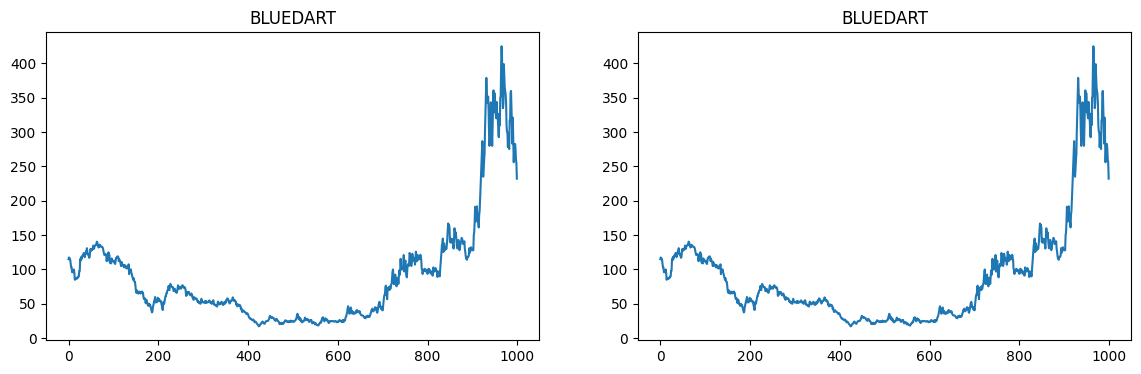

In [91]:

# test_stocks=['NHPC.csv','BLUEDART.csv']
test_stocks=['BLUEDART.csv','BLUEDART.csv']

test_dataframes=[]
# stocks=['63MOONS.csv']
path='/home/siddharth/Desktop/MultiTrading/Datasets/SCRIP/'
# path='/home/siddharth/Desktop/MultiTrading/'
timesteps=1000
for name in test_stocks:
    df=pd.read_csv(path+name)
    df=df[:timesteps]
    df=df[['Open','Close','High','Low','Volume']]
    df.reset_index(inplace=True,drop=True)
    test_dataframes.append(df)
create_subplots(n=2,df=test_dataframes,st=test_stocks)

In [92]:
import ta

def preprocess(data):
    long_sma_window = 50
    short_sma_window = 20
    data['feature_Long_SMA'] = data['Close'].rolling(window=long_sma_window, min_periods=1).mean()
    data['feature_Short_SMA'] = data['Close'].rolling(window=short_sma_window, min_periods=1).mean()
    data['feature_RSI'] = ta.momentum.rsi(close=data['Close'], window=14)
    data["feature_Close"] = data["Close"].pct_change()
    data["feature_Open"] = data["Open"]/data["Close"]
    data["feature_High"] = data["High"]/data["Close"]
    data["feature_Low"] = data["Low"]/data["Close"] 
    data['feature_MACD'] = ta.trend.macd(data["Close"])
    data['feature_CCI'] = ta.trend.cci(data["High"], data["Low"], data["Close"], window=20)
    data['feature_BB_upper'], data['feature_BB_middle'], data['feature_BB_lower'] = ta.volatility.bollinger_hband(data["Close"]), ta.volatility.bollinger_mavg(data["Close"]), ta.volatility.bollinger_lband(data["Close"])
    data['feature_Slowk']= ta.momentum.stoch(data["High"], data["Low"], data["Close"])
    data['feature_ATR'] = ta.volatility.average_true_range(data["High"], data["Low"], data["Close"], window=14)
    data.dropna(inplace=True)
    data.reset_index(inplace=True, drop=True)


In [93]:

import itertools
num_stocks=len(test_dataframes)
boxes=2*num_stocks
rng = list(range(boxes + 1)) * num_stocks
wt_combs=[]
lol=set(i for i in itertools.permutations(rng, num_stocks) if sum(i) == boxes)
for i in lol:
    wt_combs.append(i)
wt_combs=np.array(wt_combs)
wt_combs_norm=wt_combs/boxes
print((wt_combs_norm))


[[1.   0.  ]
 [0.   1.  ]
 [0.75 0.25]
 [0.5  0.5 ]
 [0.25 0.75]]


In [94]:
norm_test_dataframes=[]
for i in range(len(test_dataframes)):
    df=test_dataframes[i]
    preprocess(df)
    test_dataframes[i]=df
    df = (df - df.min()) / (df.max() - df.min())
    norm_test_dataframes.append(df)

In [95]:
from Env import MultiTradingEnv;
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Testing_arr = []
LOOKBACK=5
step=0.25
positions=np.arange(0,1,step)
positions=np.append(positions,1)
Test_Env = MultiTradingEnv(dataframes_array=test_dataframes,
                    norm_dataframes=norm_test_dataframes,
                    total_timesteps=len(test_dataframes[0])-LOOKBACK-1,
                    initial_cap=100000.0,
                    features=['feature_RSI','feature_Close','feature_MACD','feature_CCI','feature_Slowk','feature_ATR'],
                    # features=['feature_Long_SMA','feature_Short_SMA','feature_RSI','feature_Close','feature_MACD','feature_CCI','feature_BB_upper','feature_BB_middle','feature_BB_lower','feature_Slowk','feature_ATR'],
                    lookback=LOOKBACK,
                    positions=positions,
                    wt_combs=wt_combs_norm,
                    )

In [96]:
args = {
        'gamma': 0.99,
        'seed': 543,
        'render': False,
        'log_interval': 10
    }


SavedAction = namedtuple('SavedAction', ['log_prob', 'log_prob_weights', 'value'])


class Policy(nn.Module):
    """
    implements both actor and critic(action head, weight head and critic head) in one model
    """
    def __init__(self,n_observations):
        super(Policy, self).__init__()

        self.affine1 = nn.Linear(n_observations, 1024)
        self.layer2=nn.Linear(1024,512)
        self.layer3=nn.Linear(512,256)
        self.layer4=nn.Linear(256,128)


        # actor's layer
        self.action_head = nn.Linear(128, len(Test_Env.positions)*Test_Env.num_stocks)
        self.weight_head = nn.Linear(128, len(Test_Env.weight_combs))

        # critic's layer
        self.value_head = nn.Linear(128, 1)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []


    def forward(self, x):
        """
        forward of both actor and critic
        """
        x = F.relu(self.affine1(x))
        x = F.relu(self.layer2(x))
        x = F.selu(self.layer3(x))
        x = F.selu(self.layer4(x))

        # actor: choses action to take from state s_t
        # by returning probability of each action
        action_prob = (self.action_head(x)).view(-1, len(Test_Env.positions),Test_Env.num_stocks)
        action_prob=F.softmax(action_prob, dim=1)
        # action_prob = F.softmax(self.action_head(x), dim=-1)
        weight_prob = F.softmax(self.weight_head(x),dim=-1).view(-1, len(wt_combs_norm))
        # critic: evaluates being in the state s_t
        state_values = (self.value_head(x))

        return action_prob, weight_prob, state_values

In [97]:
tmp=np.zeros(shape=len(Test_Env.dataframes_array[0]))
cnt=0
wts=np.ones(num_stocks)/num_stocks
for i in Test_Env.dataframes_array:
    num=(100000*wts[cnt])/np.array(i['Open'][0])
    ar=np.array(i['Open'])*num
    tmp+=ar
    cnt+=1
tmp=tmp[5:-15]
tmp/=tmp[0]
tmp*=100000

In [98]:
import pandas_ta as ta

In [106]:
import numpy as np
import math

class Donchian:
    def __init__(self, stock_array, investment, timesteps):
        self.stock_array = stock_array
        self.investment = investment/len(self.stock_array)
        self.timesteps = timesteps
        self.net_worth = np.zeros(timesteps)
        
        
    def stratergy(self):
      for i in range(len(self.stock_array)):
        self.stock_array[i][['dcl', 'dcm', 'dcu']] = self.stock_array[i].ta.donchian(lower_length = 40, upper_length = 50)

    def implement_strategy(self):
        for aapl in self.stock_array:
            in_position = False
            equity = self.investment
            no_of_shares = 0
            self.net_worth[0] += self.investment
            for i in range(1, self.timesteps):
                if aapl['High'][i] == aapl['dcu'][i] and not in_position:
                    no_of_shares = math.floor(equity / aapl.Close[i])
                    equity -= (no_of_shares * aapl.Close[i])
                    in_position = True
                    self.net_worth[i] += (equity + no_of_shares * aapl.Close[i])
                elif aapl['Low'][i] == aapl['dcl'][i] and in_position:
                    equity += (no_of_shares * aapl.Close[i])
                    no_of_shares = 0
                    self.net_worth[i] += (equity + (no_of_shares * aapl.Close[i]))
                    in_position = False
                else:
                    self.net_worth[i] += (equity + (no_of_shares * aapl.Close[i]))
            if in_position:
                equity += (no_of_shares * aapl.Close[i])
                in_position = False

            earning = round(equity - self.investment, 2)
            roi = round(earning / self.investment * 100, 2)
            print(f'EARNING: ${earning} ; ROI: {roi}%')
        return self.net_worth


timesteps = 950
investment = 100000
final_portfolio_networth = np.zeros(timesteps)
stock_array = test_dataframes

strategy1 = Donchian(stock_array, investment, timesteps)
strategy1.stratergy()
net_worth = strategy1.implement_strategy()
np.save('DS.npy',np.array(net_worth))

# plt.plot(net_worth)
# plt.plot(tmp)
# plt.plot([Testing_arr[8][i][3] for i in range(len(Testing_arr[8]))],label=f'Ep{j*ep_step}')


EARNING: $91685.4 ; ROI: 183.37%
EARNING: $91685.4 ; ROI: 183.37%


Sortino Ratio: 1.7008705511347888
Sharpe Ratio: 1.4438055340630167
Maximum Drawdown: 0.34556531683994646
ep120 209206.8
5 2 119 32


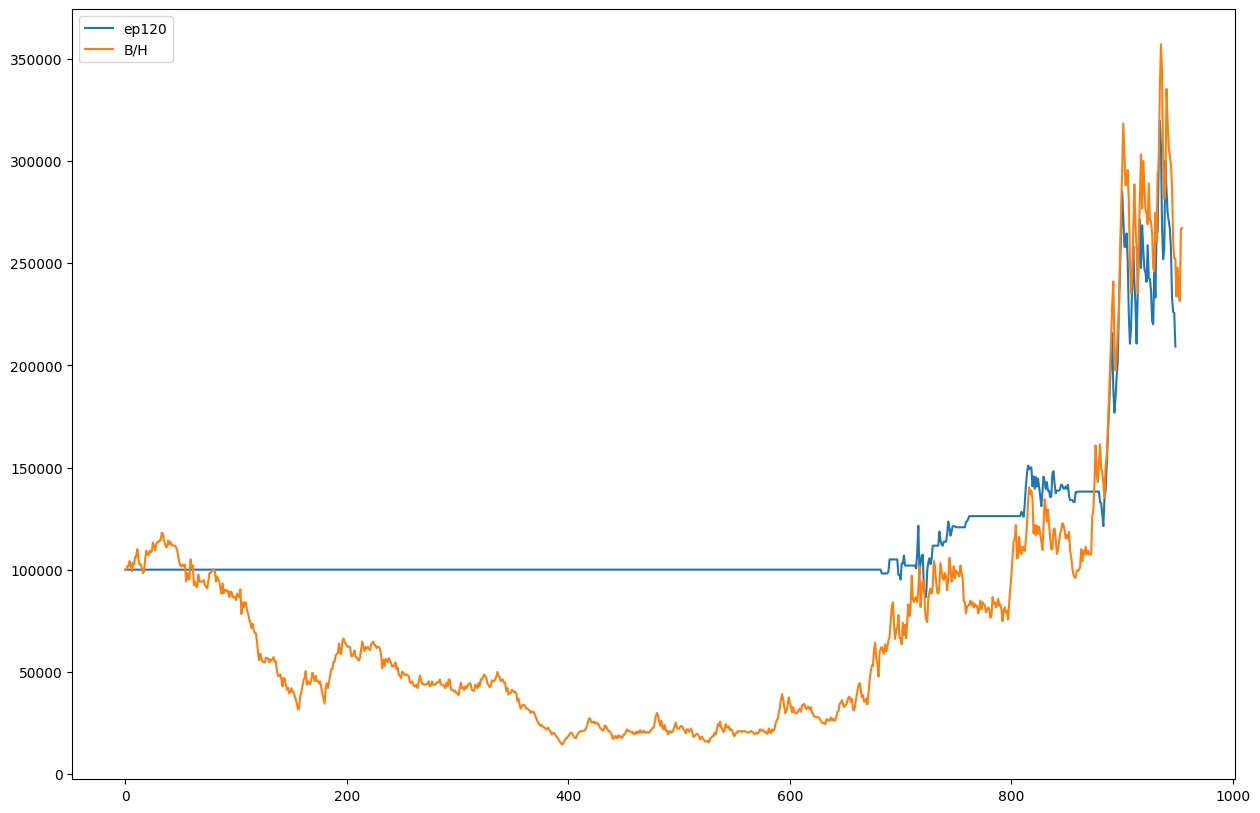

In [104]:
def sortino_ratio(returns, target_return=0):
    downside_returns = np.minimum(returns - target_return, 0)
    downside_deviation = np.sqrt(np.mean(np.square(downside_returns)))
    average_return = np.mean(returns)
    sortino_ratio = average_return / downside_deviation
    return 1+10*sortino_ratio
def sharpe_ratio(returns, risk_free_rate=0):
    average_return = np.mean(returns)
    std_deviation = np.std(returns)
    sharpe_ratio = (average_return - risk_free_rate) / std_deviation
    return 1+10*sharpe_ratio
def max_drawdown(prices):
    max_drawdown = 0
    peak = prices[0]
    for price in prices:
        if price > peak:
            peak = price
        drawdown = (peak - price) / peak
        max_drawdown = max(max_drawdown, drawdown)
    return max_drawdown
plt.figure(figsize=(15, 10))
for j in range(120,121,10):
    state=Test_Env.reset()
    # print(state.features)
    n_observations = len(state.features.flatten())
    # print(n_observations)
    model = Policy(n_observations)
    model.load_state_dict(torch.load(f'/home/siddharth/Desktop/A2C/ep{j}.pth'))
    done= 0
    hist=[]
    st=set()
    prev1=()
    prev2=()
    cnt1=0
    cnt2=0
    st2=set()
    while not done:
        state = torch.tensor(state.features, dtype=torch.float32, device=device).unsqueeze(0)
        action, weight,_ = model(state.view(-1))
        action = action.transpose(1, 2)
        action=action.detach()
        weight=weight.detach()
        actions=[]
        # print(action,weight)
        # print(action)
        for i in range(Test_Env.num_stocks):
            m = np.argmax(action[0][i])
            actions.append(m.item())
        weight_m=torch.tensor([np.argmax(weight).item()])
        # print(Test_Env.current_step,wt_combs_norm[weight_m.item()],Test_Env.shares_held, Test_Env.balance,Test_Env.net_worth)
        # print(Test_Env.shares_held, Test_Env.balance)
        if(tuple(actions)!=prev1):
            cnt1+=1
            prev1=tuple(actions)
        if(tuple(wt_combs_norm[weight_m])!=prev2):
            cnt2+=1
            prev2=tuple(wt_combs_norm[weight_m])
        st.add(tuple(actions))
        st2.add(tuple(wt_combs_norm[weight_m]))
        # print(actions,weight_m,wt_combs_norm[weight_m])
        act=torch.tensor([actions])
        hist.append(Test_Env.net_worth)
        state, reward, done= Test_Env.step(act,weight_m)
    stock_prices = hist
    stock_returns = np.diff(stock_prices) / stock_prices[:-1]
    sortino = sortino_ratio(stock_returns)
    sharpe= sharpe_ratio(stock_returns)
    maxd=max_drawdown(stock_prices)
    print("Sortino Ratio:", sortino)
    print("Sharpe Ratio:", sharpe)
    print("Maximum Drawdown:", maxd)
    print(f'ep{j} {hist[-1]}')
    print(len(st),len(st2),cnt1,cnt2)
    plt.plot(hist,label=f'ep{j}')
    np.save('A2C.npy',np.array(hist))
plt.plot(tmp,label='B/H')
# plt.plot(net_worth,label='D/S')
plt.legend()
plt.show()

Sortino Ratio: 1.7176977137863205
Sharpe Ratio: 1.4597786854140098
Maximum Drawdown: 0.8768683274021352


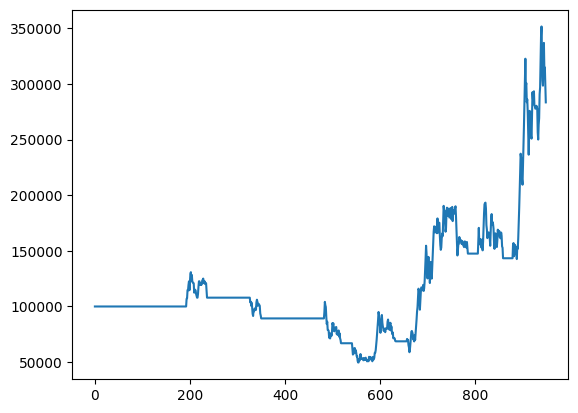

In [107]:
plt.plot(net_worth)
np.save('BH.npy',tmp)
stock_prices = tmp
stock_returns = np.diff(stock_prices) / stock_prices[:-1]
sortino = sortino_ratio(stock_returns)
sharpe= sharpe_ratio(stock_returns)
maxd=max_drawdown(stock_prices)
print("Sortino Ratio:", sortino)
print("Sharpe Ratio:", sharpe)
print("Maximum Drawdown:", maxd)